# Preempting Violent Conflict in Turkish Kurdistan: Predictive Analysis

In [51]:
# Import packages

import geopy as gp
import geopandas as gpd
import imageio
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import statsmodels.api as sm
import time
import torch
import torch.nn as nn
import torch.nn.functional as F

from collections import defaultdict
from datetime import date, timedelta
from fbprophet import Prophet
from itertools import product
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import Sequential
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from tqdm import tqdm_notebook

In [52]:
# Read data

all_data = pd.read_csv('ged211.csv', low_memory = False)

In [53]:
# Filter data, and select key variables: date, country, province, deaths

all_data['date_start'] = pd.to_datetime(all_data['date_start'])
all_data['date_start'] = all_data['date_start'].astype(str)
data = all_data[['date_start', 'country', 'adm_1', 'best']]
data = data.loc[data['country'] == 'Turkey']
data = data.loc[data['best'] > 0]
data = data.sort_values(by = 'date_start')
data = data.drop(['country'], axis = 1)
data

,date_start,adm_1,best
249398,1989-01-01,NaN,16
249399,1989-03-30,Siirt province,2
249400,1989-04-22,Siirt province,4
249401,1989-05-01,NaN,15
249402,1989-05-01,NaN,5
...,...,...,...
254125,2020-10-26,Hatay province,2
254126,2020-11-06,Hakkari province,1
254127,2020-11-10,Tunceli province,1
254128,2020-11-22,Mardin province,1


In [54]:
# Clean data

data = data.dropna(axis = 0)
turk_prov = data.drop_duplicates(subset = 'adm_1')['adm_1'].tolist()
print(turk_prov)
print(len(turk_prov))
data = data.rename(columns = {"date_start": "start_date", "adm_1": "province", "best": "deaths"}, errors = "raise")

['Siirt province', 'Gaziantep province', 'Hakkari province', 'Adıyaman province', 'Van province', 'Mardin province', 'Diyarbakır province', 'Gümüşhane province', 'Bingöl province', 'İzmir province', 'Tunceli province', 'İstanbul province', 'Kahramanmaraş province', 'Elazığ province', 'Şırnak province', 'Şanlıurfa province', 'Ağrı province', 'Malatya province', 'Kars province', 'Ankara provicne', 'Bitlis province', 'Muş province', 'Artvin province', 'Adana province', 'Batman province', 'Erzincan province', 'Bursa provicne', 'Antalya province', 'Erzurum province', 'İçel province', 'Iğdır province', 'Ardahan province', 'Sivas province', 'Hatay province', 'Tokat province', 'Ordu province', 'Kırıkkale province', 'Bayburt province', 'Denizli province', 'Osmaniye province', 'Aydın province', 'Mersin province', 'Giresun province', 'Bursa province', 'Amasya province', 'Muğla province', 'Kayseri province', 'Kilis province', 'Konya province']
49


In [55]:
# Describe data

data['start_date'].describe()
data['province'].describe()
data['deaths'].describe()

count    4715.000000
mean        5.364793
std         9.084861
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max       211.000000
Name: deaths, dtype: float64

In [56]:
# Group data by province

data_deaths = data['deaths']
# data['deaths'] = data['deaths'].apply(lambda x: (x - data_deaths.min()) / (data_deaths.max() - data_deaths.min()))
data_gb = {k: v for (k, v) in data.groupby('province')}
for i in range(len(data_gb)): print(data_gb[list(data_gb)[i]])
np.random.seed(69)

        start_date        province  deaths
249541  1991-09-06  Adana province       2
254154  1992-02-02  Adana province       1
254156  1992-02-06  Adana province       2
249610  1992-03-25  Adana province       1
254165  1992-04-30  Adana province       3
249681  1992-07-09  Adana province       2
250137  1993-11-22  Adana province       1
251301  1996-06-08  Adana province       1
251368  1996-07-28  Adana province       2
251385  1996-08-08  Adana province       6
251430  1996-09-13  Adana province       1
251471  1996-10-25  Adana province       4
252151  1999-07-05  Adana province       1
254195  1999-10-06  Adana province       2
253300  2015-07-31  Adana province       4
253392  2015-09-28  Adana province       2
254666  2016-11-24  Adana province       2
        start_date           province  deaths
249414  1989-08-10  Adıyaman province       5
249497  1991-03-05  Adıyaman province       3
254265  1991-07-28  Adıyaman province       1
249611  1992-03-30  Adıyaman province     

Auto-regressive integrated moving average (ARIMA) model

Source(s):
https://towardsdatascience.com/advanced-time-series-analysis-with-arma-and-arima-a7d9b589ed6d
https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

In [57]:
# Check ARIMA's stationarity prerequisite via augmented Dickey-Fuller test (p-value < 0.05)

ad_fuller_result = adfuller(data_kurd['deaths'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -7.9685220952022044
p-value: 2.822077539032853e-12


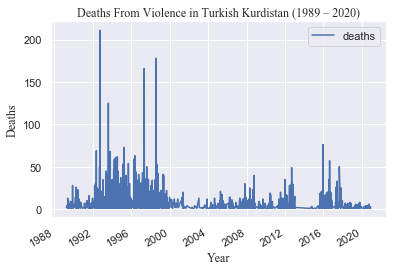

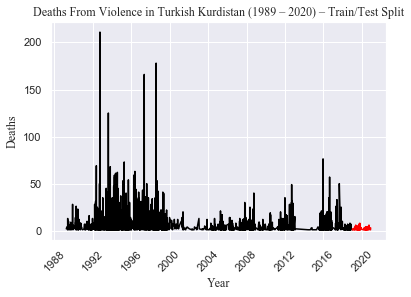

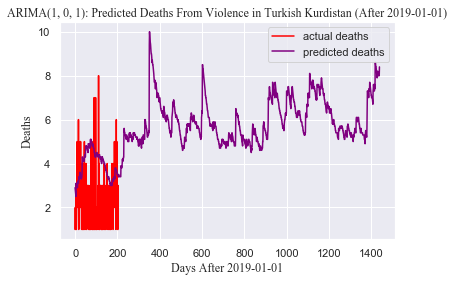

In [58]:
# ARIMA(1,0,1) model (naïve)

data_select = data[data['province'].isin(['Ardahan province', 'Ağrı province', 'Batman province', 'Bingöl province', 'Bitlis province', 'Diyarbakır province', 'Elazığ province', 'Erzincan province', 'Erzurum province', 'Gaziantep province', 'Hakkari province', 'Iğdır province', 'Kahramanmaraş province', 'Kars province', 'Kilis province', 'Malatya province', 'Mardin province', 'Muş province', 'Siirt province', 'Tunceli province', 'Van province', 'Şırnak province'])]
data_kurd = pd.DataFrame(data_select, columns = ['start_date', 'deaths'])
data_kurd = data_kurd.sort_values(by = 'start_date')
data_kurd['start_date'] = pd.to_datetime(data_kurd['start_date'])
data_kurd.index = pd.to_datetime(data_kurd['start_date'], format = '%Y-%m-%d')
del data_kurd['start_date']
data_kurd.plot(y = 'deaths', kind = 'line')
# data_gb_diyar = data_gb_diyar.rename({'start_date': 'ds', 'deaths': 'y'}, axis = 'columns')
plt.title('Deaths From Violence in Turkish Kurdistan (1989 – 2020)', fontname = "Times New Roman", fontsize = 12)
plt.ylabel('Deaths', fontname = "Times New Roman", fontsize = 12)
plt.xlabel('Year', fontname = "Times New Roman", fontsize = 12)
plt.show()

sns.set()
train_kurd = data_kurd[data_kurd.index < pd.to_datetime("2019-01-01", format = '%Y-%m-%d')]
test_kurd = data_kurd[data_kurd.index > pd.to_datetime("2019-01-01", format = '%Y-%m-%d')]
plt.plot(train_kurd, color = "black")
plt.plot(test_kurd, color = "red")
plt.title("Deaths From Violence in Turkish Kurdistan (1989 – 2020) – Train/Test Split", fontname = "Times New Roman", fontsize = 12)
plt.ylabel('Deaths', fontname = "Times New Roman", fontsize = 12)
plt.xlabel('Year', fontname = "Times New Roman", fontsize = 12)
plt.xticks(rotation=45)
plt.show()

y = train_kurd['deaths']
ARMAmodel = SARIMAX(list(y), order = (1, 0, 1))
ARMAmodel = ARMAmodel.fit()
y_pred = ARMAmodel.get_forecast(3)
y_pred_df = y_pred.conf_int(alpha = 0.05)
y_pred_out = ARMAmodel.predict()
y_pred_out = np.around(y_pred_out[5:1445], decimals = 1)
plt.plot(list(test_kurd['deaths']), color = 'red', label = 'actual deaths')
plt.plot(y_pred_out, color = 'purple', label = 'predicted deaths')
plt.title('ARIMA(1, 0, 1): Predicted Deaths From Violence in Turkish Kurdistan (After 2019-01-01)', fontname = "Times New Roman", fontsize = 12)
plt.ylabel('Deaths', fontname = "Times New Roman", fontsize = 12)
plt.xlabel('Days After 2019-01-01', fontname = "Times New Roman", fontsize = 12)
plt.legend()

In [59]:
# ARIMA(p,d,q) model (optimiser)

def optimize_ARIMA(order_list, exog):
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(exog, order = order).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([order, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']
    result_df = result_df.sort_values(by = 'AIC', ascending = True).reset_index(drop = True)
    
    return result_df

In [60]:
# Optimise ARIMA(p,d,q) at d = 0

ad_fuller_result = adfuller(data_kurd['deaths'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ps = range(0, 8, 1)
d = 0
qs = range(0, 8, 1)
parameters = product(ps, qs)
parameters_list = list(parameters)
order_list = []
for each in parameters_list:
    each = list(each)
    each.insert(1, d)
    each = tuple(each)
    order_list.append(each)
    
result_d_0 = optimize_ARIMA(order_list, exog = train_kurd['deaths'])
result_d_0

ADF Statistic: -7.9685220952022044
p-value: 2.822077539032853e-12


/Users/cyrus.hatam/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


/Users/cyrus.hatam/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/cyrus.hatam/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/cyrus.hatam/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/cyrus.hatam/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has

,"(p, d, q)",AIC
0,"(1, 0, 6)",29765.772473
1,"(6, 0, 1)",29766.532717
2,"(2, 0, 1)",29767.419081
3,"(1, 0, 7)",29767.511725
4,"(2, 0, 2)",29767.554486
...,...,...
59,"(0, 0, 3)",30581.460249
60,"(1, 0, 0)",30655.281525
61,"(0, 0, 2)",30677.969438
62,"(0, 0, 1)",30850.277116


In [61]:
# Optimise ARIMA(p,d,q) at d = 1

ps = range(0, 8, 1)
d = 1
qs = range(0, 8, 1)
parameters = product(ps, qs)
parameters_list = list(parameters)
order_list = []
for each in parameters_list:
    each = list(each)
    each.insert(1, d)
    each = tuple(each)
    order_list.append(each)
    
result_d_1 = optimize_ARIMA(order_list, exog = train_kurd['deaths'])
result_d_1

/Users/cyrus.hatam/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


/Users/cyrus.hatam/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/cyrus.hatam/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/cyrus.hatam/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/cyrus.hatam/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has

,"(p, d, q)",AIC
0,"(0, 1, 6)",29758.362740
1,"(5, 1, 1)",29759.102875
2,"(1, 1, 6)",29760.073121
3,"(0, 1, 7)",29760.115736
4,"(1, 1, 1)",29760.169338
...,...,...
59,"(4, 1, 0)",30350.583717
60,"(3, 1, 0)",30535.975463
61,"(2, 1, 0)",30783.235390
62,"(1, 1, 0)",31207.869384


In [62]:
# Optimise ARIMA(p,d,q) at d = 2

ps = range(0, 8, 1)
d = 2
qs = range(0, 8, 1)
parameters = product(ps, qs)
parameters_list = list(parameters)
order_list = []
for each in parameters_list:
    each = list(each)
    each.insert(1, d)
    each = tuple(each)
    order_list.append(each)
    
result_d_2 = optimize_ARIMA(order_list, exog = train_kurd['deaths'])
result_d_2

/Users/cyrus.hatam/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


/Users/cyrus.hatam/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/cyrus.hatam/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/cyrus.hatam/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/cyrus.hatam/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has

,"(p, d, q)",AIC
0,"(3, 2, 4)",29770.064445
1,"(2, 2, 7)",29773.547467
2,"(0, 2, 7)",29774.167451
3,"(7, 2, 4)",29775.304176
4,"(2, 2, 2)",29775.401641
...,...,...
59,"(0, 2, 1)",32206.593499
60,"(3, 2, 0)",32659.256152
61,"(2, 2, 0)",33305.877901
62,"(1, 2, 0)",34399.379935


In [63]:
# Optimise ARIMA(p,d,q) at d = 3

ps = range(0, 8, 1)
d = 3
qs = range(0, 8, 1)
parameters = product(ps, qs)
parameters_list = list(parameters)
order_list = []
for each in parameters_list:
    each = list(each)
    each.insert(1, d)
    each = tuple(each)
    order_list.append(each)
    
result_d_3 = optimize_ARIMA(order_list, exog = train_kurd['deaths'])
result_d_3

/Users/cyrus.hatam/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


/Users/cyrus.hatam/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/cyrus.hatam/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/cyrus.hatam/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/cyrus.hatam/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has

,"(p, d, q)",AIC
0,"(3, 3, 7)",29830.443917
1,"(5, 3, 6)",29841.207851
2,"(3, 3, 6)",29862.605122
3,"(2, 3, 4)",29865.381634
4,"(2, 3, 7)",29868.783004
...,...,...
57,"(3, 3, 0)",35511.718984
58,"(2, 3, 0)",36555.419951
59,"(0, 3, 1)",36649.281335
60,"(1, 3, 0)",38315.921296


In [64]:
# Print summary of best model (lowest Akaike information criterion: ARIMA(0,1,6))

best_model = SARIMAX(train_kurd['deaths'], order = (0, 1, 6)).fit()
print(best_model.summary())

/Users/cyrus.hatam/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/cyrus.hatam/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                               SARIMAX Results                                
Dep. Variable:                 deaths   No. Observations:                 4149
Model:               SARIMAX(0, 1, 6)   Log Likelihood              -14872.181
Date:                Wed, 12 Jan 2022   AIC                          29758.363
Time:                        09:52:27   BIC                          29802.675
Sample:                             0   HQIC                         29774.041
                               - 4149                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8950      0.010    -89.844      0.000      -0.915      -0.875
ma.L2         -0.0673      0.018     -3.815      0.000      -0.102      -0.033
ma.L3         -0.0100      0.022     -0.456      0.6

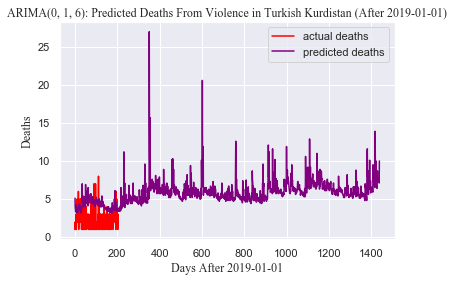

In [65]:
# Show ARIMA(0,1,6) predictions

ARMAmodel = SARIMAX(list(y), order = (0, 1, 6))
ARMAmodel = ARMAmodel.fit()
y_pred = ARMAmodel.get_forecast(3)
y_pred_df = y_pred.conf_int(alpha = 0.05)
y_pred_out = ARMAmodel.predict()
y_pred_out = np.around(y_pred_out[5:1445], decimals = 1)
plt.plot(list(test_kurd['deaths']), color = 'red', label = 'actual deaths')
plt.plot(y_pred_out, color = 'purple', label = 'predicted deaths')
plt.ylabel('Deaths', fontname = "Times New Roman", fontsize = 12)
plt.xlabel('Days After 2019-01-01', fontname = "Times New Roman", fontsize = 12)
plt.title('ARIMA(0, 1, 6): Predicted Deaths From Violence in Turkish Kurdistan (After 2019-01-01)', fontname = "Times New Roman", fontsize = 12)
plt.legend()

Random forest model

Source(s):
https://machinelearningmastery.com/random-forest-for-time-series-forecasting/
https://towardsdatascience.com/multivariate-time-series-forecasting-using-random-forest-2372f3ecbad1
https://towardsdatascience.com/a-limitation-of-random-forest-regression-db8ed7419e9f

In [66]:
# Random forest model

def series_to_supervised(data, n_in = 1, n_out = 1, dropnan = True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols = list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    agg = pd.concat(cols, axis = 1)
    if dropnan:
        agg.dropna(inplace = True)
    return agg.values
data_kurd_rf = series_to_supervised(data_kurd, n_in = 10, n_out = 1, dropnan = True)
def walk_forward_validation(data, n_test):
    predictions = list()
    train, test = train_test_split(data, n_test)
    history = [x for x in train]
    for i in range(len(test)):
        testX, testy = test[i, :-1], test[i, -1]
        yhat = random_forest_forecast(history, testX)
        predictions.append(yhat)
        history.append(test[i])
        print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
    error = mean_absolute_error(test[:, -1], predictions)
    return error, test[:, 1], predictions
def train_test_split(data, n_test):
    train_kurd_rf, test_kurd_rf = data[:n_test,:], data[n_test:,:]
    return train_kurd_rf, test_kurd_rf
def random_forest_forecast(train, testX):
    train = np.asarray(train)
    trainX, trainy = train[:, :-1], train[:, -1]
    model = RandomForestRegressor(n_estimators = 100)
    model.fit(trainX, trainy)
    yhat = model.predict([testX])
    return yhat[0]
mae, y, yhat = walk_forward_validation(data_kurd_rf, 4149)
print('MAE: %.3f' % mae)

>expected=5.0, predicted=3.5
>expected=3.0, predicted=4.7
>expected=3.0, predicted=5.3
>expected=2.0, predicted=3.2
>expected=3.0, predicted=3.4
>expected=2.0, predicted=6.3
>expected=6.0, predicted=6.2
>expected=1.0, predicted=5.1
>expected=1.0, predicted=2.7
>expected=4.0, predicted=3.5
>expected=2.0, predicted=3.4
>expected=3.0, predicted=4.4
>expected=2.0, predicted=4.2
>expected=2.0, predicted=3.6
>expected=5.0, predicted=3.8
>expected=2.0, predicted=3.0
>expected=5.0, predicted=3.1
>expected=3.0, predicted=3.4
>expected=4.0, predicted=3.2
>expected=2.0, predicted=4.2
>expected=2.0, predicted=4.3
>expected=1.0, predicted=3.5
>expected=3.0, predicted=4.9
>expected=4.0, predicted=4.0
>expected=1.0, predicted=4.2
>expected=4.0, predicted=4.0
>expected=1.0, predicted=3.5
>expected=1.0, predicted=3.1
>expected=1.0, predicted=3.6
>expected=1.0, predicted=3.1
>expected=3.0, predicted=5.7
>expected=2.0, predicted=2.7
>expected=1.0, predicted=3.2
>expected=3.0, predicted=4.2
>expected=5.0,

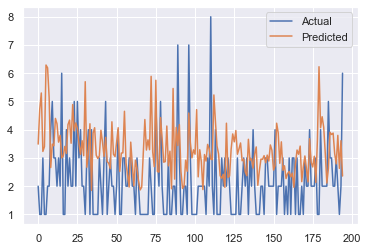

In [67]:
# Show random forest predictions

plt.plot(y, label = 'Actual')
plt.plot(yhat, label = 'Predicted')
plt.legend()
plt.show()

In [68]:
# Duplicate dataset

data_kurd_2 = data_kurd.copy()
data_kurd_2.reset_index(inplace = True)

Facebook prophet model

Source(s):
https://machinelearningmastery.com/time-series-forecasting-with-prophet-in-python/

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/cyrus.hatam/opt/anaconda3/lib/python3.7/site-packages/fbprophet/forecaster.py:400: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  (dates - pd.datetime(1970, 1, 1))
/Users/cyrus.hatam/opt/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
/Users/cyrus.hatam/opt/anaconda3/lib/python3.7/site-packages/fbprophet/forecaster.py:400: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  (dates - pd.datetime(1970, 1, 1))
/Users/cyrus.hatam/opt/anaconda3/lib/python3.7

             ds      yhat  yhat_lower  yhat_upper
1441 2022-12-12  2.272987   -8.762952   12.768162
1442 2022-12-13  2.864049   -8.292722   14.019791
1443 2022-12-14  2.322531   -9.386336   12.967984
1444 2022-12-15  2.423076   -8.935737   14.162681
1445 2022-12-16  2.881739   -7.986403   13.899546


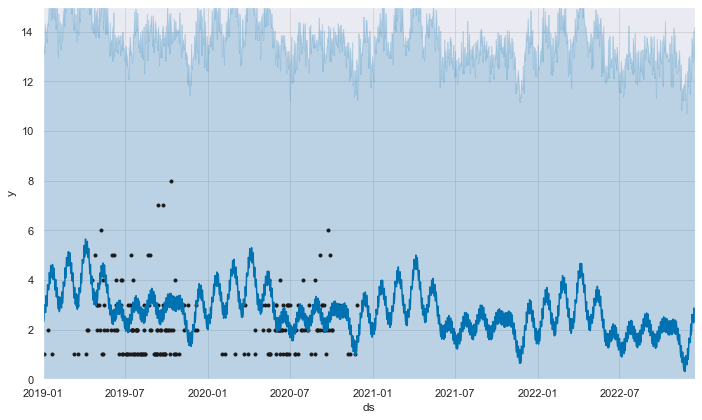

In [69]:
# Facebook prophet model

data_kurd_2.columns = ['ds', 'y']
data_kurd_2['ds'] = pd.to_datetime(data_kurd_2['ds'])
model = Prophet()
model.fit(data_kurd_2)
future = list()
start_date = date(2019, 1, 1)
end_date = date(2022, 12, 16)
delta = timedelta(days=1)
while start_date <= end_date:
    future.append([start_date])
    start_date += delta
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds'] = pd.to_datetime(future['ds'])
forecast = model.predict(future)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())
model.plot(forecast)
plt.xlim([date(2019, 1, 1), date(2022, 12, 16)])
plt.ylim([0, 15])
plt.show()